In [ ]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import os
import pandas as pd
import networkx as nx

## Triadic closure in an email network

In this notebook, we'll examine an email network from a 'large European research institution.' The dataset comes from the SNAP archive; [this page](https://snap.stanford.edu/data/email-Eu-core-temporal.html) has more information. The data were originally published in the paper: 

> Ashwin Paranjape, Austin R. Benson, and Jure Leskovec. "Motifs in Temporal Networks." In Proceedings of the Tenth ACM International Conference on Web Search and Data Mining, 2017. 

Each edge in the network is an email from one person to another, and each email has a timestamp. So the network has information about the time that each edge was created. In this demo, we'll use this time information to try to find evidence for triadic closure. The general approach will be to divide the time covered in the dataset into two periods: the first and second half.

### Load the data

In [6]:
data_url = "https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz"
#data_url = os.path.expanduser(os.path.join("~", "Dropbox", "data-explore", "email-eu-core", "email-Eu-core-temporal.txt.gz"))

In [7]:
%%time
raw_data = pd.read_csv(data_url, sep=" ", header=None)

CPU times: user 339 ms, sys: 109 ms, total: 448 ms
Wall time: 2.19 s


In [8]:
raw_data.head()

,0,1,2
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


Let's rename the columns based on the [dataset description](https://snap.stanford.edu/data/email-Eu-core-temporal.html).

In [9]:
# rename the columns
raw_data = raw_data.rename(index=str, columns={0 : "from", 1 : "to", 2 : "time"})
raw_data.head()

,from,to,time
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


It looks like time starts and 0 and goes up

In [ ]:
raw_data['time'].describe()

Let's get the halfway time

In [10]:
t_half = np.median(raw_data['time'])
t_half

23719190.0

Now create a directed, non-simple network object from the dataset

In [11]:
%%time

# create a network from the message logs
raw_net = nx.from_pandas_edgelist(raw_data, 
                                   source='from', 
                                   target='to', 
                                   edge_attr=['time'], 
                                   create_using=nx.MultiDiGraph())

CPU times: user 3.9 s, sys: 322 ms, total: 4.22 s
Wall time: 5.7 s


This function will be helpful for creating a simple, undirected network from the directed, non-simple network. We'll do this by only keeping edges that are reciprocated. We'll keep track of how many emails were exchanged between each pair of connected nodes, and this will be the edge weight.

Optionally, we can specify `time_cutoff`; if this is specified, we'll only keep edges whose timestamp is <= the cutoff.

In [12]:
def to_undirected_weighted(g, time_cutoff = None):
    
    # filter out directed edges between nodes where connection is reciprocated
    # (and also self-loops, if there are any)
    if time_cutoff is not None:
        di_edges_recip = [(u,v,d) for (u,v,d) in g.edges(data=True) if (v,u) in g.edges() and v != u and d['time'] <= time_cutoff]
    else:
        di_edges_recip = [(u,v,d) for (u,v,d) in g.edges if (v,u) in g.edges() and v != u]
        
    print("there are ", len(di_edges_recip), " reciprocated edges in the original network.")
    
    # now create an undirected network with edges weighted by the number of interactions
    new_net = nx.Graph()
    for edge in di_edges_recip:
        # if the edge is already in the network, add one to its weight
        if (edge[0], edge[1]) in new_net.edges:
            new_net[edge[0]][edge[1]]['weight'] = new_net[edge[0]][edge[1]]['weight'] + 1
        # otherwise, add it
        else:
            new_net.add_edge(edge[0], edge[1], weight=1)

    print("undirected net, # nodes: ", new_net.number_of_nodes())
    print("undirected net, avg degree: ", 2*new_net.number_of_edges()/new_net.number_of_nodes())
    
    return(new_net)

Using the function above, create an undirected version of the entire network (i.e., the network at the end of time):

In [13]:
%%time 

t1_net = to_undirected_weighted(raw_net)

there are  304566  reciprocated edges in the original network.
undirected net, # nodes:  776
undirected net, avg degree:  22.8479381443299
CPU times: user 2.79 s, sys: 50.6 ms, total: 2.84 s
Wall time: 3.53 s


And create a second network that has only emails sent before the halfway point:

In [14]:
%%time 

t0_net = to_undirected_weighted(raw_net, time_cutoff = t_half)

there are  152181  reciprocated edges in the original network.
undirected net, # nodes:  692
undirected net, avg degree:  19.739884393063583
CPU times: user 2.7 s, sys: 29.9 ms, total: 2.73 s
Wall time: 3.35 s


## Looking for evidence of triadic closure

Now we have an undirected version of the network at time 0, and at time 1. Let's see if we can find evidence of triadic closure.

The general idea is to

* find all pairs of nodes that are *not* connected by an edge at the end of the first time period
* count the number of mutual neighbors they have. (If they have at least one mutual neighbor, they form an unclosed triad)
* store the results in a dataframe

In [15]:
%%time

# this dictionary will keep track of
# the num common neighbors between pairs of unlinked nodes
# it will map a frozenset with two unconnected nodes to the
# number of common neighbors of the two nodes
unlinked_node_ncn = {}

from itertools import combinations

# go through all pairs of nodes in the network
for u,v in combinations(t0_net.nodes, 2):
    cur_key = frozenset([u,v])
    
    # ignore self-loops
    if u == v:
        next
    # ignore edges that already exist
    if (u,v) in t0_net.edges:
        next
        
    # and skip this pair if we've already calculated the number
    # of shared neighbors they have
    if cur_key in unlinked_node_ncn:
        next
    
    # get the number of common neighbors, and store it in the dict
    num_common_nbrs = len([x for x in nx.common_neighbors(t0_net, u, v)])
    unlinked_node_ncn[cur_key] = num_common_nbrs
    

CPU times: user 14.9 s, sys: 203 ms, total: 15.1 s
Wall time: 20.8 s


There are almost 240,000 pairs of nodes not joined by an edge at the end of the first time period.

In [16]:
len(unlinked_node_ncn.keys())

239086

Let's turn the dictionary we constructed into something easier to work with -- a dataframe

In [17]:
node_pairs = pd.DataFrame.from_dict(unlinked_node_ncn, orient='index', columns=['num_common_nbrs'])
node_pairs.index.name = 'node_pair'
node_pairs = node_pairs.reset_index()
node_pairs

,node_pair,num_common_nbrs
0,"(764, 582)",5
1,"(105, 582)",0
2,"(580, 582)",0
3,"(994, 582)",9
4,"(433, 582)",6
5,"(690, 582)",0
6,"(582, 175)",2
7,"(329, 582)",8
8,"(582, 231)",11
9,"(173, 582)",2


Now we want to go through and, for each pair of nodes in our dataframe, check to see whether or not an edge has formed between the two nodes by the end of the second time period.

This function will help: given a row in the dataframe, it returns 1 if the two nodes have been linked at the end of the second time period, and 0 otherwise.

In [18]:
def exists_t1(row, net):
    u, v = list(row['node_pair'])
    if (u,v) in net.edges:
        return 1
    return 0

node_pairs['link_formed'] = node_pairs.apply(exists_t1, axis=1, net=t1_net)

Now we've added a column that shows whether or not each pair of nodes was eventually linked.

In [19]:
node_pairs.head()

,node_pair,num_common_nbrs,link_formed
0,"(764, 582)",5,1
1,"(105, 582)",0,1
2,"(580, 582)",0,1
3,"(994, 582)",9,1
4,"(433, 582)",6,1


What fraction of possible links was formed? It looks like about 3.5% of them.

In [20]:
np.mean(node_pairs['link_formed'])

0.03527600946939595

### Looking for evidence of triadic closure

The triadic closure hypothesis says that unconnected nodes that share a common neighbor are more likely to form an edge than unconnected nodes that do not share a common neighbor. 

Let's see if this seems to be true in this email dataset: we can compare (i) the probability that a link formed between pairs of nodes with no common neighbor; and (ii) the probability that a link formed between pairs of nodes with at least one common neighbor.

In [21]:
node_pairs['any_common_nbr'] = node_pairs.apply(lambda x: int(x['num_common_nbrs'] > 0), axis=1)
node_pairs

,node_pair,num_common_nbrs,link_formed,any_common_nbr
0,"(764, 582)",5,1,1
1,"(105, 582)",0,1,0
2,"(580, 582)",0,1,0
3,"(994, 582)",9,1,1
4,"(433, 582)",6,1,1
5,"(690, 582)",0,1,0
6,"(582, 175)",2,1,1
7,"(329, 582)",8,1,1
8,"(582, 231)",11,1,1
9,"(173, 582)",2,1,1


In [22]:
node_pairs_any_agg = node_pairs.groupby('any_common_nbr').agg({'link_formed' : [np.mean]})
node_pairs_any_agg = node_pairs_any_agg.xs('link_formed', axis=1, drop_level=True).reset_index()
node_pairs_any_agg

,any_common_nbr,mean
0,0,0.002815
1,1,0.096146


This might be easier to see with a plot

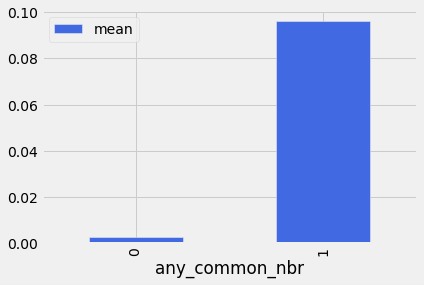

In [23]:
node_pairs_any_agg.plot('any_common_nbr', 'mean', color='royalblue', kind='bar');

In [ ]:
9.6/.3

It looks like nodes that have some common neighbor are about 9.6/.3 = 32 times more likely to form a connection than nodes with no common neighbor. This supports the triadic closure hypothesis.

### Do more common neighbors increase the chances of triadic closure?

Next, we'll try to look at the probability that a link formed, as a function of the number of common neighbors.

Get fraction of links formed by number of common neighbors

In [30]:
node_pairs_agg = node_pairs.groupby('num_common_nbrs').agg({'link_formed' : [np.mean, np.std, len]})
node_pairs_agg = node_pairs_agg.xs('link_formed', axis=1, drop_level=True).reset_index()
node_pairs_agg

,num_common_nbrs,mean,std,len
0,0,0.002815,0.052985,155931
1,1,0.015466,0.123399,36790
2,2,0.036461,0.187439,15935
3,3,0.075369,0.264002,8664
4,4,0.112139,0.315566,5511
5,5,0.159968,0.366625,3732
6,6,0.206264,0.404700,2618
7,7,0.247118,0.431444,1995
8,8,0.318436,0.466032,1432
9,9,0.364726,0.481559,1168


Plotting the results, we can see that it gets noisy at higher values of number of common neighbors, when the sample size presumably gets very small.

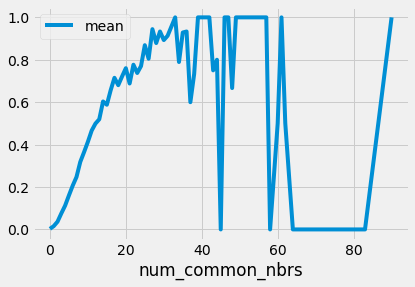

In [25]:
node_pairs_agg.plot('num_common_nbrs', 'mean')

If we focus on fewer than 25 common neighbors, we start to see evidence of the pattern we're looking for.

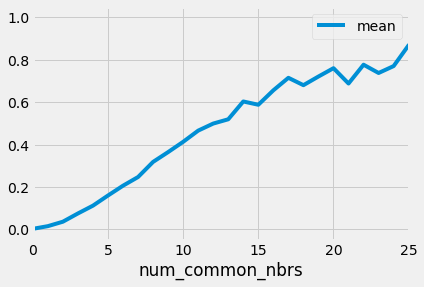

In [26]:
node_pairs_agg.plot('num_common_nbrs', 'mean', xlim=(0,25))

Let's see if we can make this a bit simpler by categorizing `num_common_nbrs` into a smaller number of bins

In [27]:
node_pairs['ncn_bins'] = pd.cut(node_pairs['num_common_nbrs'],
                                bins=[0,1,2,3,4,5,100],
                                labels=['0', '1', '2', '3', '4', '5+'],
                                right=False)

In [28]:
node_pairs_bin_agg = node_pairs.groupby('ncn_bins').agg({'link_formed' : [np.mean, np.std, len]})
node_pairs_bin_agg = node_pairs_bin_agg.xs('link_formed', axis=1, drop_level=True).reset_index()
node_pairs_bin_agg

,ncn_bins,mean,std,len
0,0,0.002815,0.052985,155931
1,1,0.015466,0.123399,36790
2,2,0.036461,0.187439,15935
3,3,0.075369,0.264002,8664
4,4,0.112139,0.315566,5511
5,5+,0.342910,0.474696,16255


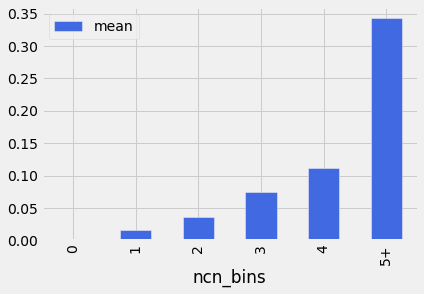

In [29]:
node_pairs_bin_agg.plot('ncn_bins', 'mean', kind='bar', color='royalblue')

It looks like the more common neighbors two unlinked nodes have, the more likely it is an edge will form between them.